# Discussion 06 - Linear Support Vector Machines

In this example, we will be using [the Wine Dataset from UCI](https://archive.ics.uci.edu/ml/datasets/wine). <br >
The data is the results of a chemical analysis of wines grown in the same region in Italy. <br >
There are 13 different measurements taken from 3 types of wines(cultivators/grapevines).

We will use this dataset to build a linear Support Vector Machine. <br >

### Goals
- Support Vector Machines with Linear Kernel
- Hard Margin and Soft Margin
- Hinge Loss
- Extendning to Multi-class classification
- The impact of imbalance on SVM


Instruction: Yun-Hsin Kuo.

### Troubleshooting for installing cvxpy

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install cvxpy

### Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
data, classes = load_wine(return_X_y=True, as_frame=True) 
data['class'] = classes
df = data.copy()
# This is like one vs. one
df = df.loc[(df['class'] != 2)]
df = df.replace({"class": {0: -1}})

df['class'].value_counts() 

 1    71
-1    59
Name: class, dtype: int64

In [2]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=21)

X_train, y_train = train.copy().drop(columns=['class']), train['class']
X_test, y_test = test.copy().drop(columns=['class']), test['class']
y_train.value_counts()

 1    61
-1    43
Name: class, dtype: int64

In [3]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/1200/0*MgG8zoCB6CY4Fa19.gif')

## Linear Support Vector Machine

### Overview
The main objective of SVM is to find an optimal hyperplane ( decision boundary ) that **distinctly separates two groups** of points. <br >
Ideally, all members of one group should fall on one side of the hyperplane. The other group should all fall on the other side. <br >

How should we define which hyperplane to be optimal? <br >
We would like that **the margin to be maximized**, where the margin is decided by some points from each class that are closest to the hyperplane. <br >
These "some points" are known as support vectors. <br >
Why maximized? To get higher confidence when classifying points. <br >
Typically, SVM is used to solve **binary classification** problem. <br >

Note: Points $X$ fall above the boundary are annotated with label $y = +1$. <br >
On the other hand, those fall below the boundary are annotated with label $y = -1$. <br >
(But you don't have to worry about labelling "correctly" when using the SVM.)

In [4]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/494px-SVM_margin.png')

In [5]:
Image(url='https://miro.medium.com/max/1288/1*RdSqcpreH0fEfXoT2Njj9Q.png')

### Formulation
**Distinctly separate two groups of points**

$w^{T}x_n + b \geq 1, \forall y_n = +1$

$w^{T}x_n + b \leq -1, \forall y_n = -1$

By multiplying our label, we can combine these two ( dashed hyperplane ) to summarize our optimal decision boundary:

$y_{n}(w^{T}x_n + b) \geq 1$

Why we are picking 1 not 2? Because the weights can be scaled as well. <br > 

**Maximizing the margin**

It is the same as maximizing the [projected distance](https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_plane),

$\text{maximize} \dfrac{2}{||w||}$

which is **minimizing our coefficients $\text{minimize} \dfrac{||w||}{2}$, or $\dfrac{||w||^2}{2}$**

Note that $||w||^2$ is squared sum of our coefficients. <br >

We can put these two together to get a optimization problem defined as follow:

$\begin{equation*}
\begin{array}{ll@{}ll}
\text{min}  & \displaystyle \dfrac{1}{2} {||w||}^2 & \\
\text{s.t.}& \displaystyle y_{n}(w^{T}x_n + b) \geq 1 & \forall n\\
\end{array}
\end{equation*}$

Formally, this is a quadratic programming problem in its **primal** form for a **Hard-margin SVM**.

We can use some convex optimization library to solve this problem, such as [cvxpy](https://www.cvxpy.org/) or [cvxopt](https://cvxopt.org/)

In [6]:
import cvxpy as cp
class LinearSVM:
    def __init__(self, soft=False, C=1):
        self.relax = soft
        self.C = C
        self.D = None # number of features/dimensions
        self.N = None # number of training data points
        
        self.X = None
        self.y = None
        
        self.w = None
        self.b = None
        self.e = None
        
    def fit(self, X, y):
        (self.N, self.D) = X.shape
        self.X = np.asarray(X)
        self.y = np.asarray(y).reshape(-1, 1)
        
        w = cp.Variable((self.D, 1))
        b = cp.Variable()
        e = cp.Variable((self.N, 1))
        
        if self.relax:
            objective = cp.Minimize(cp.sum(cp.square(w)) * 0.5 + cp.sum(e) * self.C)
            constraints = [cp.multiply(self.y, (self.X @ w + b)) >= 1 - e, e >=0]
        else:
            objective = cp.Minimize(cp.sum(cp.square(w)) * 0.5)
            constraints = [cp.multiply(self.y, (self.X @ w + b)) >= 1]
            
        prob = cp.Problem(objective, constraints)
        
        prob.solve()
        self.w = w.value
        self.b = b.value
        self.e = e.value
        print(f'Status: {prob.status}')
        print(f"Objective Value: {prob.value}")
        
    def predict(self, X):
        return np.sign((np.asarray(X) @ self.w + self.b))
        
    def getSupportVec(self):
        if self.relax:
            return (self.y * (self.X @ self.w + self.b) - 1 + self.e <= 1e-10)
        else:
            return (self.y * (self.X @ self.w + self.b) - 1 <= 1e-10)
        
    def getParams(self):
        return self.w

In [7]:
from sklearn.metrics import classification_report
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

svm = LinearSVM()
svm.fit(scaler.transform(X_train), y_train)

display(pd.DataFrame(svm.getParams().reshape(1, -1), columns=X_train.columns))

# Printing out support vectors
display(train.loc[svm.getSupportVec(), :])

print(classification_report(y_train, svm.predict(scaler.transform(X_train))))
print(classification_report(y_test, svm.predict(scaler.transform(X_test))))

Status: optimal
Objective Value: 1.5284343930564752


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.985456,-0.172531,-0.590935,0.557765,-0.062248,0.021138,0.141533,-0.086204,-0.146001,-0.432311,0.296567,-0.565671,-0.864722


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
27,13.30,1.72,2.14,17.0,94.0,2.40,2.19,0.27,1.35,3.95,1.02,2.77,1285.0,-1
68,13.34,0.94,2.36,17.0,110.0,2.53,1.30,0.55,0.42,3.17,1.02,1.93,750.0,1
81,12.72,1.81,2.20,18.8,86.0,2.20,2.53,0.26,1.77,3.90,1.16,3.14,714.0,1
43,13.24,3.98,2.29,17.5,103.0,2.64,2.63,0.32,1.66,4.36,0.82,3.00,680.0,-1
95,12.47,1.52,2.20,19.0,162.0,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937.0,1
73,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.35,1.31,3.50,985.0,1
25,13.05,2.05,3.22,25.0,124.0,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830.0,-1
124,11.87,4.31,2.39,21.0,82.0,2.86,3.03,0.21,2.91,2.80,0.75,3.64,380.0,1
121,11.56,2.05,3.23,28.5,119.0,3.18,5.08,0.47,1.87,6.00,0.93,3.69,465.0,1
44,13.05,1.77,2.10,17.0,107.0,3.00,3.00,0.28,2.03,5.04,0.88,3.35,885.0,-1


              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        61

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

              precision    recall  f1-score   support

          -1       1.00      0.94      0.97        16
           1       0.91      1.00      0.95        10

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26



### Sanity check on Hard-margin SVM
Generally, the difference between LinearSVC() and SVC(kernel='linear') is the algorithm implementation, liblinear and libsvm. <br >
LinearSVC() put more focus on scalability. <br >
Here is [how they are different](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

In [8]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report

scaler = preprocessing.StandardScaler()

clf = SVC(kernel='linear')
clf_li = LinearSVC(dual=False)

scaler.fit(X_train)

clf.fit(scaler.transform(X_train), np.asarray(y_train))
clf_li.fit(scaler.transform(X_train), np.asarray(y_train))

print(classification_report(y_test, clf.predict(scaler.transform(X_test))))
print(classification_report(y_test, clf_li.predict(scaler.transform(X_test))))

              precision    recall  f1-score   support

          -1       1.00      0.94      0.97        16
           1       0.91      1.00      0.95        10

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26

              precision    recall  f1-score   support

          -1       1.00      0.94      0.97        16
           1       0.91      1.00      0.95        10

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26



### Soft-margin SVM

Often we just cannot separate the two groups perfectly. <br >
So we should allow some violations, i.e., relax the margins, by adding slack variables. <br >

$\begin{equation*}
\begin{array}{ll@{}ll}
\text{min}  & \displaystyle \dfrac{1}{2} {||w||}^2 + C \cdot \sum_{n}\xi_n& \\
\text{s.t.}& \displaystyle y_{n}(w^{T}x_n + b) \geq 1 - \xi_n & \forall n\\
  & \displaystyle \xi_n \geq 0 & \forall n\\
\end{array}
\end{equation*}$

When $ 0 \leq \xi_n \leq 1$, it means $x_n$ stays within the margin, but $\xi_n \geq 1$ implies that $x_n$ is misclassified. <br >

$C$ is a hyperparameter that lets you decide how much you'd like to avoid misclassification. Small value of $C$ leads to more misclassified points. <br >

In [9]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

svm = LinearSVM(soft=True, C=10)
svm.fit(scaler.transform(X_train), y_train)

display(train.loc[svm.getSupportVec(), :])

print(classification_report(y_train, svm.predict(scaler.transform(X_train))))
print(classification_report(y_test, svm.predict(scaler.transform(X_test))))

Status: optimal
Objective Value: 1.5284343930564752


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
27,13.30,1.72,2.14,17.0,94.0,2.40,2.19,0.27,1.35,3.95,1.02,2.77,1285.0,-1
68,13.34,0.94,2.36,17.0,110.0,2.53,1.30,0.55,0.42,3.17,1.02,1.93,750.0,1
81,12.72,1.81,2.20,18.8,86.0,2.20,2.53,0.26,1.77,3.90,1.16,3.14,714.0,1
43,13.24,3.98,2.29,17.5,103.0,2.64,2.63,0.32,1.66,4.36,0.82,3.00,680.0,-1
95,12.47,1.52,2.20,19.0,162.0,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937.0,1
73,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.35,1.31,3.50,985.0,1
25,13.05,2.05,3.22,25.0,124.0,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830.0,-1
124,11.87,4.31,2.39,21.0,82.0,2.86,3.03,0.21,2.91,2.80,0.75,3.64,380.0,1
121,11.56,2.05,3.23,28.5,119.0,3.18,5.08,0.47,1.87,6.00,0.93,3.69,465.0,1
44,13.05,1.77,2.10,17.0,107.0,3.00,3.00,0.28,2.03,5.04,0.88,3.35,885.0,-1


              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        61

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

              precision    recall  f1-score   support

          -1       1.00      0.94      0.97        16
           1       0.91      1.00      0.95        10

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26



### Hinge Loss

The constraints do not really constrain any points when they are very far away from the hyperplane, i.e., when the points are not support vectors. <br >
We can rewrite our penalty in this way, 

$\begin{equation}
       \text{Hinge} = 
        \begin{cases}
            0 & \text{if } y \cdot (w^{T}x + b) \geq 1 \\
            1 - y \cdot (w^{T}x + b) & \text{else}
        \end{cases}
\end{equation}$

Or,

$\text{Hinge} = \max(0, 1 - y \cdot (w^{T}x + b))$

Now we remove the slack variables and do not have any constraints, the problem of our Soft-margin now becomes:

$\text{minimize } \displaystyle \lambda{||w||}^2 + \sum_{i=1}^n \max \left( 0,(1 - y_i \cdot (w^{T}x_i + b))\right)$

We now have one more regularization parameter to prevent overfitting, and we can use gradient descents to update the coefficients. <br >
You can find the gradients in lecture videos. Or see the [cvxpy implementation](https://www.cvxpy.org/examples/machine_learning/svm.html) here. <br >


### Multi-class SVM
SVM is only solves binary classification. To extend to multiple classes, there are two approaches. <br >
Say if we have $k$ classes, 

 - One-vs-all: The default on scikit-learn. Building $k$ SVMs.
     - Class 0 vs. \[Class 1, Class 2\]
     - Class 1 vs. \[Class 0, Class 2\]
     - Class 2 vs. \[Class 0, Class 1\]
 - One-vs-one: Building ${k \choose 2} = \dfrac{k(k-1)}{2}$ SVMs.
     - Class 0 vs. Class 1
     - Class 0 vs. Class 2
     - Class 1 vs. Class 2

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=21)

X_train, y_train = train.copy().drop(columns=['class']), train['class']
X_test, y_test = test.copy().drop(columns=['class']), test['class']
y_train.value_counts()

1    61
0    44
2    37
Name: class, dtype: int64

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

clf_ovo = SVC(kernel='linear', decision_function_shape='ovo') # The other is ovr

clf_ovo.fit(scaler.transform(X_train), np.asarray(y_train))

print(classification_report(y_test, clf_ovo.predict(scaler.transform(X_test))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.90      0.95        10
           2       0.92      1.00      0.96        11

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



### Takeaway of LinearSVM covered above
 - Can only do binary classification
 - Assumes the data is **linearly separable**

We mentioned a term "primal" eariler for our optimization problem. <br >
Generally, we can view the optimization problem from two perspectives, one is primal form, another is **dual form**. <br >
"dual" version helps us classify non-linearly separable dataset by allowing us to do **kernel trick**.

### Impact of Imbalance on SVM and how SVM handles

The class weight will be applied to our hyperparameter $C$, such that the class assigned with a higher weight will have higher misclassification penalties.

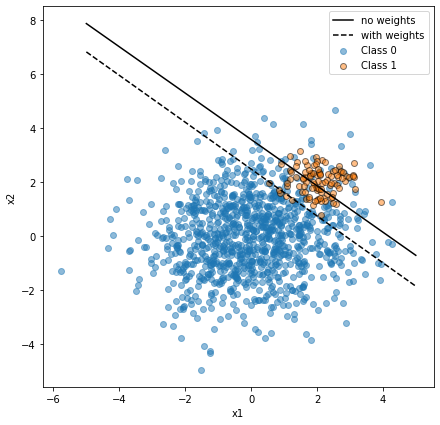

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

# Create artificial dataset
N1 = 1000
N2 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(n_samples=[N1, N2], centers=centers, cluster_std=clusters_std, random_state=21, shuffle=False)

# Unweighted
clf = SVC(kernel='linear')
clf.fit(X, y)

x1 = np.linspace(-5, 5)

w1, w2 = clf.coef_.reshape(-1) 
b = clf.intercept_.reshape(-1)
x2 = (-(w1)* x1 - b) / w2

# Weigthed
wclf = SVC(kernel='linear', class_weight={1: 10}) # Class 1 is our minority
wclf.fit(X, y)

w1, w2 = wclf.coef_.reshape(-1) 
b = clf.intercept_.reshape(-1)
x2_w = (-(w1)* x1 - b) / w2

#### plotting ####
plt.figure(figsize=(7, 7))
plt.plot(x1, x2, 'k-', label='no weights')
plt.plot(x1, x2_w, 'k--', label='with weights')
plt.scatter(X[(y == 0),0], X[(y == 0),1], c='tab:blue', alpha=.5, label='Class 0')
plt.scatter(X[(y == 1),0], X[(y == 1),1], c='tab:orange', alpha=.5, label='Class 1', edgecolors='k')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

plt.show()